In [413]:
#!jt -l

In [414]:
#!jt -t grade3 -f roboto -fs 12 -cellw 100% -dfs 10 -ofs 10

# ML Project: Creating the Dataset

*Note: All datasets were updated in June 2021.*

*At first, when updating, noticeable changes occurred. Instance count jumped from 50 to 60 to 75 within two weeks. Then, after about a month (early November), changes were insignificant and the number of countries reached its steady state with about 80 countries.*

We'll join multiple datasets on a common feature. The common feature is 'Country'

In [415]:
import pandas as pd
import matplotlib.pyplot as plt 

In [416]:
cases_data=pd.read_csv("../COVID dataset/latest_try.csv")
population_data=pd.read_csv("../COVID dataset/population.csv")
countries_data=pd.read_csv("../COVID dataset/countries of the world.csv")
usefulfeatures_data=pd.read_csv("../COVID dataset/countries useful features.csv")
GDP_data=pd.read_csv("../COVID dataset/GDP.csv")
HF_data=pd.read_csv("../COVID dataset/hf score.csv")
literacy1_data=pd.read_csv("../COVID dataset/literacy rate 1.csv")

In [417]:
#cases_data.info()

Select the desired feature from the datasets then join them. We chose population and density.

Make sure that the column 'Country' is written identicaly 

In [418]:
#population_data.info()

In [419]:
population_data=population_data.rename(columns={'Country (or dependency)':'Country','Density (P/Km²)':'Density','Population (2020)':'Population'})

population_data=population_data.filter(items=['Country','Population','Density'])

cases_data=cases_data.rename(columns={'location':'Country'})

cases_data=cases_data.filter(items=['date','Country','total_cases','total_tests','tests_per_case','extreme_poverty','human_development_index','hospital_beds_per_thousand','handwashing_facilities','continent','reproduction_rate','total_deaths','positive_rate'])

result=population_data.join(cases_data.set_index('Country'), on='Country')

Change 'date' from object to datetime. datetime allows us to apply helpful operations of our date features

In [420]:
result['date'] = result['date'].apply(pd.to_datetime)

Only select countries where cases reached at least 1% of its population. 

Apply minimum function. Now the date when cases reached 1% is selected.

In [421]:
#result.info()

In [422]:
#mortality_rate=result.loc[result['date']=="2021-02-08"]['total_deaths']/result.loc[result['date']=="2021-02-08"]['total_cases']

In [423]:
#result['mortality_rate']=mortality_rate
#result['reproduction_rate_mortality'] = result.loc[result['date']=="2021-01-22"]['reproduction_rate']
#result['total_deaths_mortality'] = result.loc[result['date']=="2021-02-05"]['total_deaths']

In [424]:
#result[['Country','mortality_rate']]

In [425]:
PERCENTGE = 0.10 #change depedning on the desired %
result2=result.loc[result['total_cases']>=PERCENTGE*result['Population']]

result2=result2.set_index('Country')

result2=result2.min(axis=0,level='Country')

C:\Users\ahmad\AppData\Local\Temp/ipykernel_11016/921691462.py:6: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.median(level=1) should use df.groupby(level=1).median().
  result2=result2.min(axis=0,level='Country')


In [426]:
result2.reset_index().Country.nunique()

98

In [427]:
result2['mortality_rate'] = result2['total_deaths']/result2['total_cases']

In [428]:
#result2.info()

Join with the next dataset (countries_data). We'll select 'Climate' from this dataset.

Note: We applied str.strip() to remove spaces from the begining and end of the country column. This dataset (countries of the world) has a space at the begining of each country. To correctly join them the 'Country' column has to be identical. 

In [429]:
#countries_data.info()

In [430]:
result2=result2.reset_index()

countries_data=countries_data.filter(items=['Country','Region','Climate'])
countries_data['Country']=countries_data['Country'].str.strip()

We noticed that we don't need the feature 'Region' as we'll be using 'continent' from another dataset.

Drop features with NULL climate.

In [431]:
countries_data=countries_data.dropna(subset=["Climate"])
countries_data=countries_data.reset_index(drop=True)

countries_data.drop('Region',axis='columns', inplace=True)

countriesData=result2.set_index('Country').join(countries_data.set_index('Country'))

Join with the next dataset (useful features data). 

We'll select Tourism, Date of first case, Latitude, Longitude, Lockdown date, and Lockdown type.

In [432]:
#usefulfeatures_data.info()

In [433]:
countriesData=countriesData.reset_index()

usefulfeatures_data=usefulfeatures_data.filter(items=['Country_Region','Tourism','Date_FirstConfirmedCase','Latitude','Longtitude','Lockdown_Date','Lockdown_Type'])
usefulfeatures_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184 entries, 0 to 183
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Country_Region           184 non-null    object 
 1   Tourism                  184 non-null    int64  
 2   Date_FirstConfirmedCase  184 non-null    object 
 3   Latitude                 184 non-null    float64
 4   Longtitude               184 non-null    float64
 5   Lockdown_Date            151 non-null    object 
 6   Lockdown_Type            151 non-null    object 
dtypes: float64(2), int64(1), object(4)
memory usage: 10.2+ KB


Change date from object to datetime

In [434]:
usefulfeatures_data=usefulfeatures_data.rename(columns={'Country_Region':'Country'})

usefulfeatures_data['Lockdown_Date']=usefulfeatures_data['Lockdown_Date'].apply(pd.to_datetime)
usefulfeatures_data['Date_FirstConfirmedCase']=usefulfeatures_data['Date_FirstConfirmedCase'].apply(pd.to_datetime)

countriesData=countriesData.set_index('Country').join(usefulfeatures_data.set_index('Country'))

Rename the date column. Drop total cases, we don't need it.

In [435]:
countriesData=countriesData.reset_index()

countriesData=countriesData.rename(columns={'date':'Date to reach 1%'})

#countriesData=countriesData.drop(['total_cases'], axis=1)

Join the next dataset (GDP). We'll use the feature GDP from this dataset.

In [436]:
#GDP_data.info()

In [437]:
GDP_data=GDP_data.filter(items=['Country ','2017','2018'])

GDP_data=GDP_data.rename(columns={'Country ':'Country'})

From the GDP dataset, we'll be using values collected from 2018. Some 2018 values are null so fill them with older 2017 GDP values.

Then, drop 2017 GDP column as we don't need it anymore

In [438]:
GDP_data['2018']=GDP_data['2018'].fillna(GDP_data['2017'])

GDP_data=GDP_data.drop(['2017'], axis=1)

GDP_data=GDP_data.rename(columns={'2018':'GDP 2018'})

countriesData=countriesData.set_index('Country').join(GDP_data.set_index('Country'))

Join the next dataset (HF data). We'll select the human freedom score from this dataset.

In [439]:
HF_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162 entries, 0 to 161
Columns: 120 entries, year to ef_rank
dtypes: float64(43), int64(13), object(64)
memory usage: 152.0+ KB


In [440]:
HF_data=HF_data.filter(items=['countries','hf_score'])

HF_data=HF_data.rename(columns={'countries':'Country','hf_score':'HF score 2017'})

countriesData=countriesData.reset_index()

countriesData=countriesData.set_index('Country').join(HF_data.set_index('Country'))

In [441]:
countriesData=countriesData.reset_index()
countriesData=countriesData.reset_index()

Join the next dataset (literacy data). We selected the average literacy rate.

In [442]:
literacy1_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   country                          150 non-null    object 
 1    literacy_rate_percent_all       150 non-null    object 
 2    male_literacy_percent_rate      150 non-null    float64
 3    female_literacy_percent_rate    150 non-null    float64
 4    gender_difference_percentWorld  150 non-null    float64
 5   86.3                             1 non-null      float64
 6   90.0                             0 non-null      float64
 7   82.7                             0 non-null      float64
 8   7.3	                             0 non-null      float64
dtypes: float64(7), object(2)
memory usage: 10.7+ KB


In [443]:
literacy1_data=literacy1_data.filter(items=['country',' literacy_rate_percent_all'])

literacy1_data=literacy1_data.rename(columns={'country':'Country',' literacy_rate_percent_all':'literacy rate'})

countriesData=countriesData.set_index('Country').join(literacy1_data.set_index('Country'), on='Country')

countriesData=countriesData.reset_index()

We now have our dataset ready! 

Save it in the project repository.

In [444]:
len(countriesData)

98

In [445]:
countriesData.to_csv('10%_try.csv',index=False)

In [446]:
countriesData.loc[countriesData['Country']=='Libya']

,Country,index,Population,Density,Date to reach 1%,total_cases,total_tests,tests_per_case,extreme_poverty,human_development_index,...,Climate,Tourism,Date_FirstConfirmedCase,Latitude,Longtitude,Lockdown_Date,Lockdown_Type,GDP 2018,HF score 2017,literacy rate


(array([29., 24., 20., 14.,  5.,  2.,  2.,  0.,  0.,  1.]),
 array([0.00031249, 0.00651953, 0.01272658, 0.01893362, 0.02514067,
        0.03134771, 0.03755476, 0.0437618 , 0.04996885, 0.0561759 ,
        0.06238294]),
 <BarContainer object of 10 artists>)

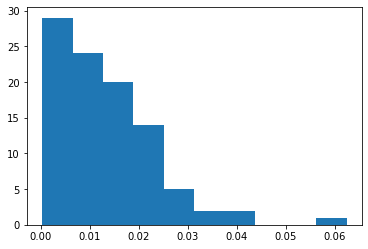

In [447]:
plt.hist(countriesData['mortality_rate'])